In [ ]:
# Bot check

# HW_ID: ds_ml6
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

## Применение реализованных модулей (60 баллов)
Для начала определим путь до ноутбука с реализованными модулями.

In [2]:
# Путь к папке с заданием
path_to_dir: str = ''
# Путь к файлу с модулями
path_to_modules_notebook = path_to_dir + "дз1_modules.ipynb"

In [ ]:
# В Google Colab подключаемся к диску
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_modules_notebook = "drive/MyDrive/" + path_to_modules_notebook

Следующая ячейка делает `from 1_modules.ipynb import *`, таким образом позволяя этому ноутбуку видеть все модули.

In [3]:
%run $path_to_modules_notebook

test_LeakyReLU (__main__.TestLayers) ... ok
test_Linear (__main__.TestLayers) ... ok
test_LogSoftMax (__main__.TestLayers) ... ok
test_NLLCriterion (__main__.TestLayers) ... ok
test_ReLU (__main__.TestLayers) ... ok
test_Sequential (__main__.TestLayers) ... c:\Users\rusin\Desktop\физкек\ФПМИ\ДС-поток\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
ok
test_SoftMax (__main__.TestLayers) ... ok

----------------------------------------------------------------------
Ran 7 tests in 1.066s

OK


После того, как все слои в `1_modules.ipynb` протестированы и работают корректно, проверим нейросеть на наборах синтетических данных.

In [4]:
import numpy as np
from sklearn import datasets

import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch
import torch.nn as nn
from torch.optim import SGD as torch_sgd

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF3300', '#00CC66'])
RANDOM_SEED = 42

sns.set(font_scale=1, palette='Set2')
np.random.seed(RANDOM_SEED)

Будем применять реализованные модули на синтетических данных.

### 1. Линейно разделимая выборка (35 баллов)

Обучим однослойную нейронную сеть решать линейно-разделимую классификацию на 2 класса.

In [5]:
n_samples = 1024
n_classes = 2

varied_blobs = datasets.make_blobs(
    n_samples=n_samples,
    n_features=2,
    centers=n_classes,
    cluster_std=[1.0, 2.5],
    random_state=RANDOM_SEED
)

sample, labels = varied_blobs

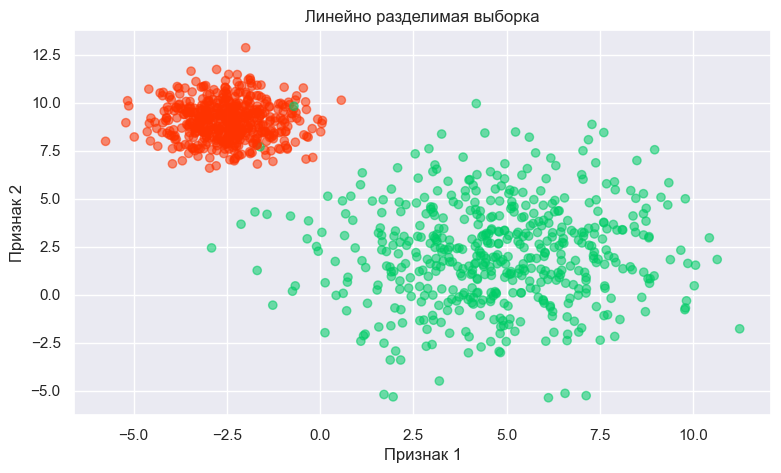

In [6]:
plt.figure(figsize=(9, 5))
plt.title('Линейно разделимая выборка')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55);

Генератор батчей. Помним, что нейросети обучаются итеративно $-$ по батчам.

In [7]:
def train_generator(sample, labels, batch_size):
    '''
    Генератор батчей.
    На каждом шаге возвращает `batch_size` объектов из `sample` и их
    меток из `labels`.
    '''
    n_samples = sample.shape[0]
    # Перемешиваем в случайном порядке в начале эпохи
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # Обратите внимание на yield вместо return
    # (если раньше не сталкивались с генераторами)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx], labels[batch_idx]

Функция для удобного обучения модели.

In [8]:
def train_model(
    model,
    sample, y,
    criterion,
    opt_params,
    n_epoch,
    batch_size
):
    '''
    Обучает модель из вашего мини-фреймворка.
    Возвращает обученную модель, историю значений функции потерь
    и метрики качества.

    :param `model`: модель из вашего мини-фреймворка
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''

    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            model.zero_grad_params()

            # Forward pass
            pred = model.forward(x_batch)
            loss = criterion.forward(pred, y_batch)
            
            # Backward pass
            grad_last = criterion.backward(pred, y_batch)
            model.backward(x_batch, grad_last)

            # Обновление весов
            SGD(model.get_parameters(),
                model.get_grad_params(),
                opt_params)
            loss_history.append(loss)

        display.clear_output(wait=True)

        plt.figure(figsize=(6, 4))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.title(f'Loss: {loss:.3f}')
        plt.show()

    return model, loss_history

Построим однослойную нейросеть для классификации: размер слоя $2 \times 2$, так как 2 признака и 2 класса. В качестве последнего слоя рекомендуется использовать `LogSoftMax`.

In [9]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 2
LogSoftMax



Объявим оптимизируемую функцию потерь и гиперпараметры.

In [10]:
# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Проверим, что кодирование производится верно.

In [11]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 1 0 1 1 1 1 1 0]
[[1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


Обучим модель с помощью функции `train_model`.

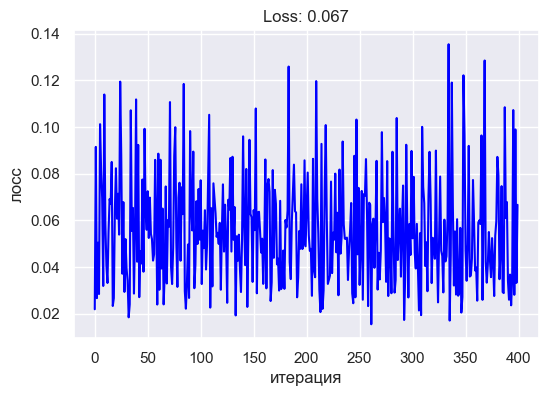

In [15]:
net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

Поменяйте гиперпараметр `learning_rate` в `optimizer_config` на `1e-1`, `1e-2`, `1e-3` и `1e-4`.

Как это влияет на обучение?

In [14]:
def set_lr_experiment(lr):
    '''Запускает тот же эксперимент с данным lr'''
    optimizer_config = {'learning_rate' : lr}

    return train_model(
        net,
        sample, y,
        criterion,
        optimizer_config,
        n_epoch,
        batch_size
    )

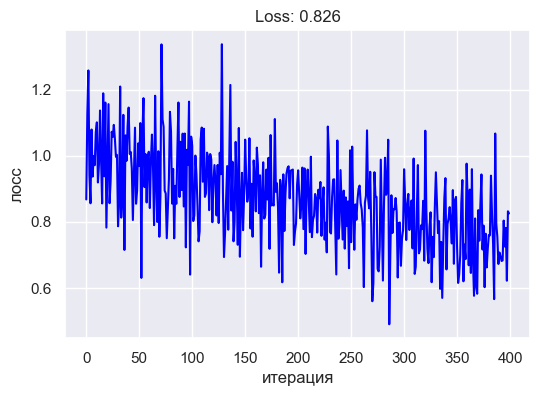

In [17]:
loss_histories = []
lrs = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lrs:
    net = Sequential()
    net.add(Linear(2, 2))
    net.add(LogSoftMax())
    criterion = NLLCriterion()
    net, loss_history = set_lr_experiment(lr)
    loss_histories.append(loss_history)

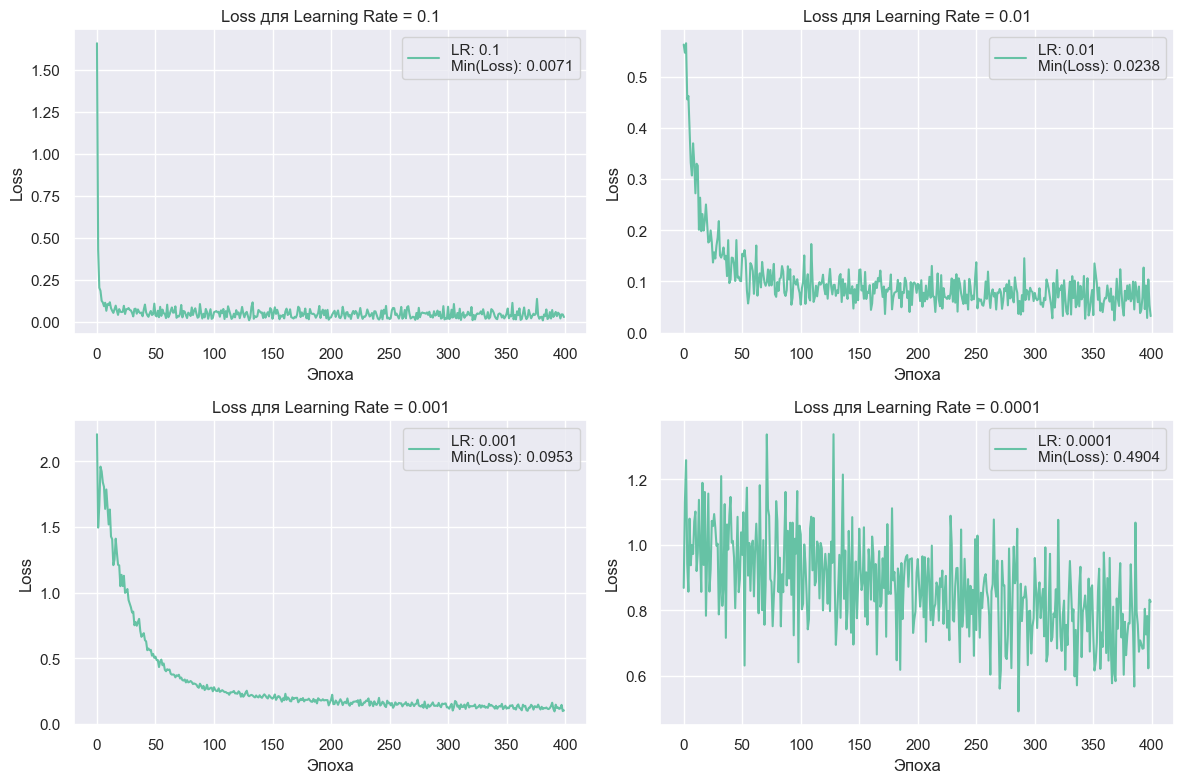

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Построим четыре подграфика потерь для каждого learning rate
for i, (lr, loss_history) in enumerate(zip(lrs, loss_histories)):
    ax = axs[i // 2, i % 2]
    ax.plot(loss_history, label=f'LR: {lr}' + '\n'+  f'Min(Loss): {min(loss_history):.4f}')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel('Loss')
    ax.set_title(f'Loss для Learning Rate = {lr}')
    ax.legend()

plt.tight_layout()
plt.show()

**Вывод**

С уменьшением learning rate возрастает ошибка. Когда learning rate слишком мал, изменения весов происходят очень медленно, и модель может "застрять" в окрестностях локального минимума или идти к глобальному минимуму чрезвычайно долго. Также может происходить переобучение. Итак, оптимальный параметр learning rate = 0.1

Батч-генератор для тестовой выборки.

In [22]:
def generate_grid(sample, h=0.02):
    '''
    Генерирует двумерную сетку,
    возвращает 2 сетки - координаты x и координаты y
    '''
    x_min, x_max = sample[:, 0].min() - .5, sample[:, 0].max() + .5
    y_min, y_max = sample[:, 1].min() - .5, sample[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def test_generator(sample):
    '''
    Батч-генератор для тестовых данных (без меток).
    '''
    n_samples = sample.shape[0]
    indices = np.arange(n_samples)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield sample[batch_idx]

Функции для удобного тестирования модели.

In [23]:
def test_model(model, test_sample):
    '''
    Тестирует модель на тестовой выборке.
    '''
    preds = []
    for test_batch in test_generator(test_sample):
        batch = model.forward(test_batch)
        batch = batch.argmax(axis=1).reshape(-1,1)
        preds.append(batch)
    preds = np.vstack(preds)
    return preds


def plot_grid_preds(sample, labels, xx, yy, preds, title):
    '''
    Функция для удобной отрисовки предсказаний нейросети на двумерной сетке.
    '''
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.scatter(sample[:, 0], sample[:, 1], c=labels, cmap=cm_bright, alpha=0.55)
    plt.contourf(xx, yy, preds, alpha=.2, cmap=cm)
    plt.show();

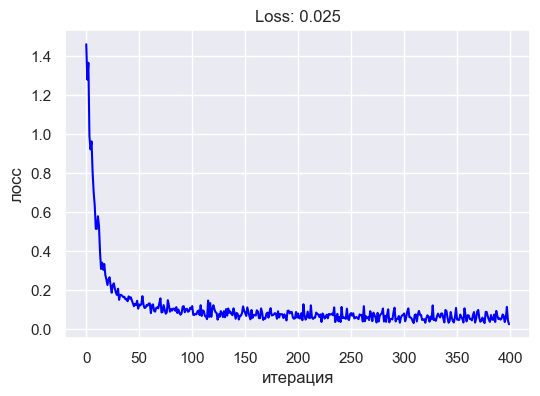

In [24]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

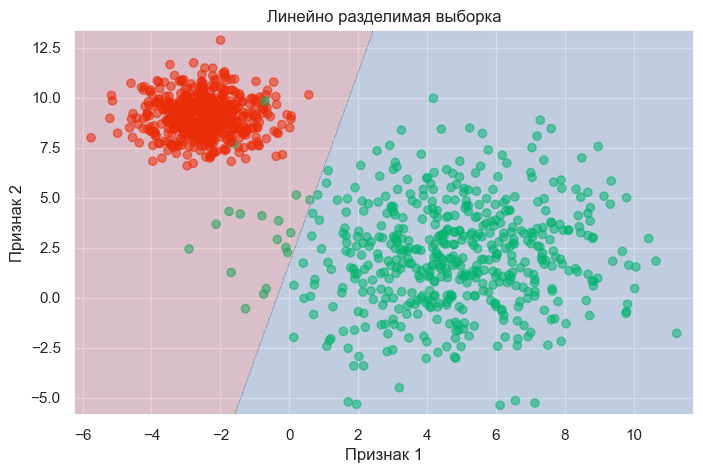

In [25]:
xx, yy = generate_grid(sample)
# получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(
    sample,
    labels,
    xx, yy,
    test_predictions,
    'Линейно разделимая выборка'
)

Сравним с точно такой же моделью, но на PyTorch.

*Подсказка.* Названия слоев идентичны, если брать их из `torch.nn`. Отличия только в оптимизаторе и названии функции потерь.

In [26]:
net_torch = nn.Sequential(
    nn.Linear(2, 2),
    nn.LogSoftmax()
)

print(net_torch)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSoftmax(dim=None)
)


In [27]:
def train_model_torch(
    model,
    sample, y,
    criterion,
    optimizer,
    n_epoch,
    batch_size
):
    '''
    Обучает модель из PyTorch.
    Возвращает обученную модель, историю значений функции потерь
    и метрики качества.

    :param `model`: модель из PyTorch
    :param `sample`: матрица объектов
    :param `y`: вектор истинных меток объектов
    :param `criterion`: функция потерь
    :param `opt_params`: гиперпараметры оптимизатора
    :param `n_epoch`: количество эпох
    :param `batch_size`: размер одного батча
    '''

    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in train_generator(sample, y, batch_size):
            # Обнуляем градиенты с предыдущей итерации
            optimizer.zero_grad()
            
            # Forward pass
            # Backward pass
            # Обновление весов
            pred = model(x_batch)
            loss = criterion(pred, y_batch[:, 1])
            loss.backward()
            loss_history.append(loss.data)
            optimizer.step()

        display.clear_output(wait=True)

        plt.figure(figsize=(6, 5))
        plt.title("Функция потерь на train")
        plt.xlabel("итерация")
        plt.ylabel("лосс")
        plt.plot(loss_history, 'b')
        plt.show()
        print('Current loss: %f' % loss)

    return model, loss_history

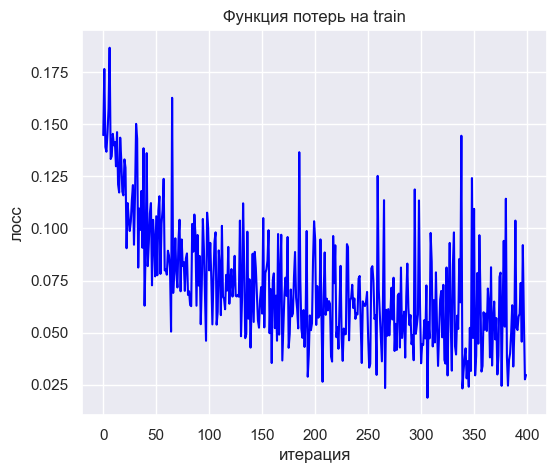

Current loss: 0.029693


In [33]:
criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=1e-2)

net_torch, loss_history = train_model_torch(
    net_torch, torch.tensor(sample).float(), torch.tensor(y).long(),  # преобразуем метки в Long
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

*Для самопроверки.* Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| Linear(2,2) |  1e-2         | 0.1 и ниже |

In [34]:
def test_torch(model, test_sample):
    '''
    Тестирует модель из PyTorch на тестовой выборке.
    '''
    preds = []
    with torch.no_grad():
        for test_batch in test_generator(test_sample):
            preds_batch = model(torch.FloatTensor(test_batch))
            preds_batch = preds_batch.argmax(axis=1).reshape(-1,1)
            preds.append(preds_batch.detach().numpy())
    preds = np.vstack(preds)
    return preds

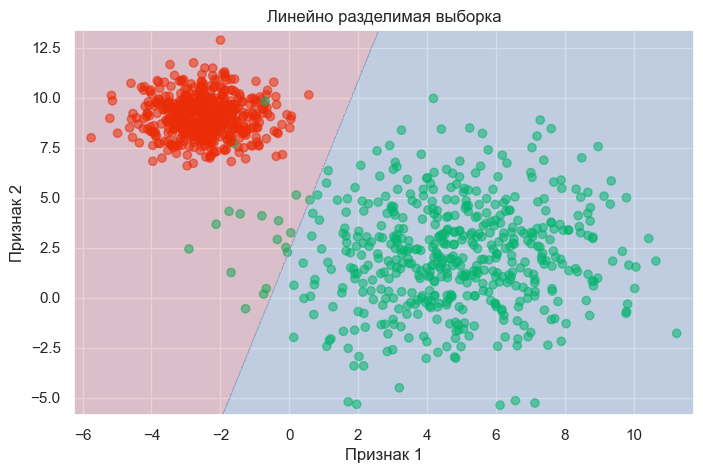

In [35]:
xx, yy = generate_grid(sample)
# получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(
    sample,
    labels,
    xx, yy,
    test_predictions,
    'Линейно разделимая выборка'
)

Рисунки с предсказаниями должны практически совпадать у вашей модели и у модели на PyTorch.

### 2. Вложенные окружности (30 баллов)

Проверим работу нейросети на более сложной выборке, которая линейно не разделима в исходном пространстве признаков.

In [36]:
n_samples = 1024

noisy_circles = datasets.make_circles(
    n_samples=n_samples,
    factor=.5,
    noise=.05
)

sample, labels = noisy_circles

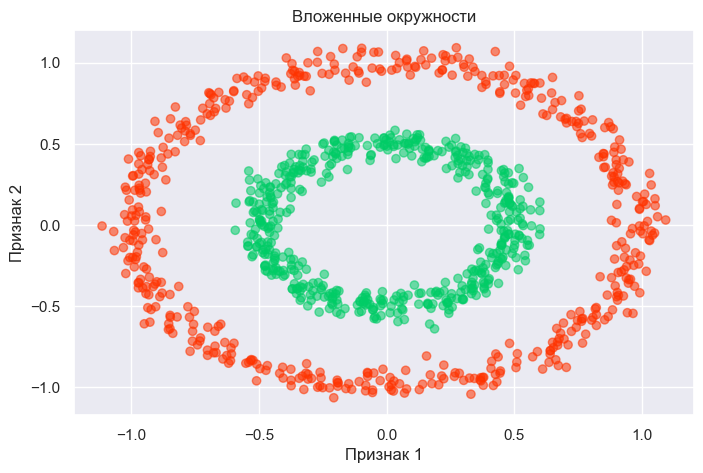

In [37]:
plt.figure(figsize=(8, 5))
plt.title('Вложенные окружности')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.scatter(sample[:,0], sample[:,1], c=labels, cmap=cm_bright, alpha=0.55);

Сначала попробуем обучить и протестировать однослойную нейросеть:

In [38]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())
print(net)

# Функция потерь
criterion = NLLCriterion()

# Гиперпараметры оптимизатора
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}

# Гиперпараметры цикла обучения и генератора
n_epoch = 50
batch_size = 128

Linear 2 -> 2
LogSoftMax



In [39]:
y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)
print(labels[:10])
print(y[:10])

(1024, 2)
[0 1 0 0 1 1 1 0 0 1]
[[1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]


Обучим и визуализируем предсказания:

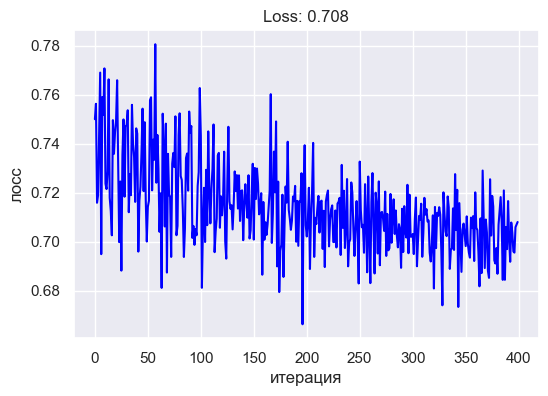

In [40]:
net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    n_epoch,
    batch_size
)

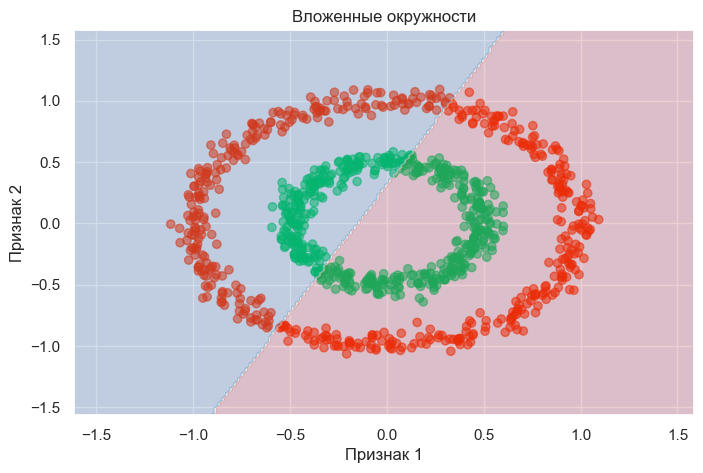

In [41]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy,
                test_predictions, 'Вложенные окружности')

Вряд ли у вас получился лосс ниже 0.68 и адекватный рисунок. Это говорит о том, что один слой не может решить задачу.

Попробуем сделать **двухслойную** нейросеть. Не жалейте нейронов в скрытый слой. Окружности должны хорошо отделяться начиная с 30-40 нейронов.

*Подсказка.* Не забудьте про нелинейности.

In [57]:
net = Sequential()
net.add(Linear(2,100))
net.add(ReLU())
net.add(Linear(100,2))
net.add(LogSoftMax())
print(net)

criterion = NLLCriterion()

optimizer_config = {'learning_rate' : 1}

n_epoch = 150
batch_size = 128

y = np.hstack([1 - labels[:, None], labels[:, None]])
print(y.shape)

Linear 2 -> 100
ReLU
Linear 100 -> 2
LogSoftMax

(1024, 2)


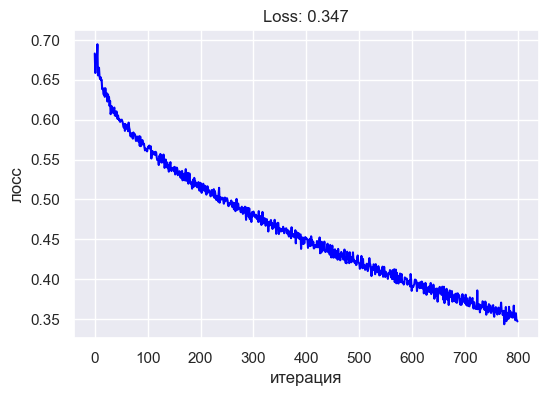

In [58]:
net, loss_history = net, loss_history = train_model(
    net,
    sample, y,
    criterion,
    optimizer_config,
    100,
    batch_size
)

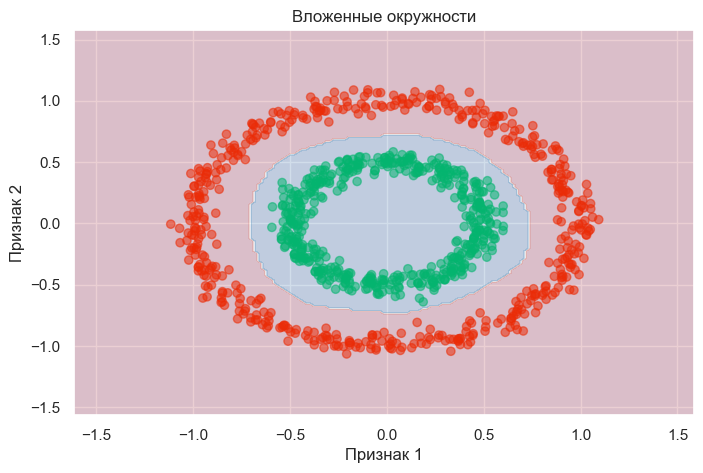

In [59]:
xx, yy = generate_grid(sample)
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_model(net, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy, test_predictions, 'Вложенные окружности')

И снова сравним с PyTorch.

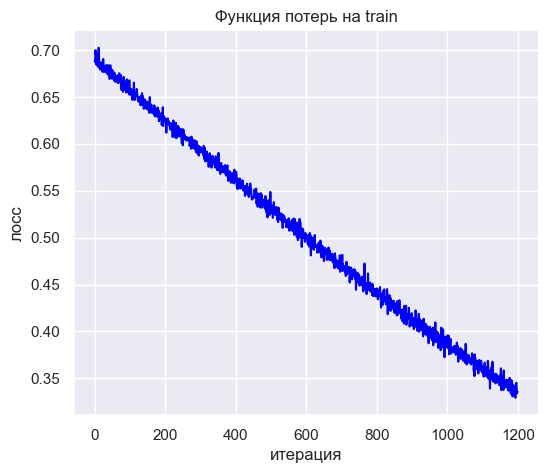

Current loss: 0.335997


In [62]:
net_torch = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 2),
    nn.LogSoftmax()
)

print(net_torch)

criterion = nn.NLLLoss()
optimizer = torch_sgd(net_torch.parameters(), lr=0.01)

net_torch, loss_history = train_model_torch(
    net_torch, torch.tensor(sample).float(), torch.tensor(y),
    criterion,
    optimizer,
    n_epoch,
    batch_size
)

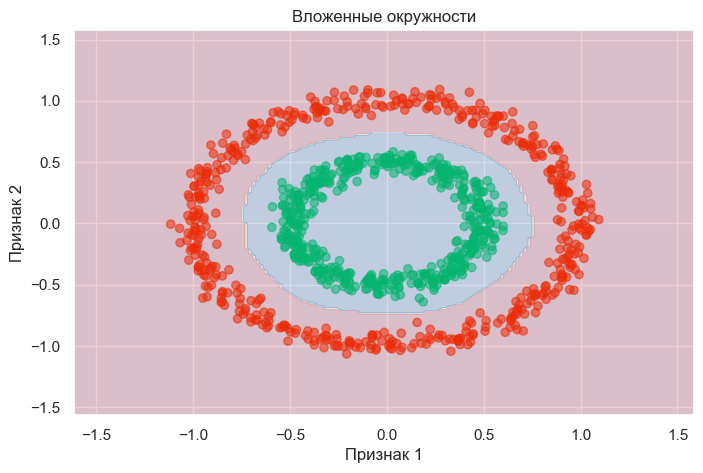

In [61]:
xx, yy = generate_grid(sample)
# получим набор точек с 2 координатами
test_sample = np.c_[xx.ravel(), yy.ravel()]

test_predictions = test_torch(net_torch, test_sample)
test_predictions = test_predictions.reshape(xx.shape)

plot_grid_preds(sample, labels, xx, yy,
                test_predictions, 'Вложенные окружности')

*Для самопроверки*. Значение функции потерь (лосса) должны быть примерно одинаковые у вашей модели и у сети из PyTorch. Каким именно на этом датасете $-$ см. таблицу ниже.

|  Архитектура  | learning_rate | Значение лосса |
|-------------|---------------|-------------|
| (2,100) -> ReLU -> (100,2) |  1e-2         | 0.5 и ниже |

Оба рисунка должны примерно совпадать и адекватно разделять окружности между собой (одна область должна быть "внутри" другой).

### 3. Заключение (5 баллов)

Сделайте выводы по проведенным экспериментам.

**Выводы.**
Успешно реализовали свою нейросеть, результаты на данных идентичны Pytorch.

### Полезные ссылки

- [Заметки главы ИИ в Tesla Andrej Karpathy по обучению нейросетей](http://karpathy.github.io/2019/04/25/recipe/)
- [Backpropagation на brilliant.org](https://brilliant.org/wiki/backpropagation/)
- См. ссылки в `1_modules.ipynb`